In [78]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import requests
from datetime import datetime

Preberemo csv

In [79]:
# getting csv files from the folder MyProject
path = "./data/"

panj = pd.read_csv(r'./data/Table_V_Colony_inspection.csv')

C:\Users\borbr\AppData\Local\Temp\ipykernel_8500\2124618982.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  panj = pd.read_csv(r'./data/Table_V_Colony_inspection.csv')


različne spremenljivke

In [80]:
print(panj['paramText'].unique())

['Number of worker brood cells' 'Number of adult bees' 'Number of eggs'
 'Number of cells honey' 'Number of beebread cells' 'Number of larvae'
 'Number of other cells' 'Number of cells nectar'
 'Number of departing foragers' 'Number of returning foragers'
 'Colony weight']


In [81]:
panj.head()

,resId,siteNo,hiveNo,frameNo,sampY,sampM,sampD,sampT,paramText,anMethText,resVal,resUnit,resUnit_desc,resValUncert,resValUncertSD,resQualValue
0,CA83295,6,12,frame 2A,2020,6,20,11,Number of worker brood cells,Video and image analysis,0.0,G293A,comb cell,NaN,NaN,NaN
1,NAB7202,6,12,frame 3A,2020,4,8,12,Number of adult bees,Comb inspection,1700.0,G199A,animal,NaN,NaN,NaN
2,CA68341,1,1,frame 13B,2020,4,22,11,Number of worker brood cells,Video and image analysis,0.0,G293A,comb cell,NaN,NaN,NaN
3,CA90078,5,11,frame 15A,2020,5,22,12,Number of worker brood cells,Video and image analysis,0.0,G293A,comb cell,NaN,NaN,NaN
4,CA75191,6,11,frame 7B,2020,4,8,11,Number of eggs,Video and image analysis,15.0,G293A,comb cell,NaN,NaN,NaN


extractamo podatke o teži

In [82]:
panj = panj.loc[panj['paramText'] == "Colony weight"]

In [83]:
panj.head()

,resId,siteNo,hiveNo,frameNo,sampY,sampM,sampD,sampT,paramText,anMethText,resVal,resUnit,resUnit_desc,resValUncert,resValUncertSD,resQualValue
151242,CW207717,3,1,NaN,2019,5,29,6,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN
151243,CW207716,3,1,NaN,2019,5,29,5,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN
151244,CW207715,3,1,NaN,2019,5,29,4,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN
151245,CW207714,3,1,NaN,2019,5,29,3,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN
151246,CW207713,3,1,NaN,2019,5,29,2,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN


naredimo datetime

In [84]:
###     IZBRISI POTEM   ###
#panj = panj.loc[panj['sampY'] == 2019]
#panj = panj.loc[panj['sampM'] == 6]
#panj = panj.loc[panj['sampD'] == 29]
###     TEST            ###

In [85]:
panj = panj.rename(columns={'sampY': 'year', 'sampM': 'month', 'sampD': 'day', 'sampT': 'hour'})
panj = panj[panj.day != 00] #neke meritve imajo dan 00, kar pythonu ni vsec
panj["date"] = pd.to_datetime(panj[['year', 'month', 'day', 'hour']])
#panj["date"] = pd.to_datetime(panj.year*10000+panj.month*100+panj.day+0.1*panj.day,format='%Y%m%d%H')
panj = panj.drop(['year', "month", "day"], axis=1)

In [86]:
panj.head()

,resId,siteNo,hiveNo,frameNo,hour,paramText,anMethText,resVal,resUnit,resUnit_desc,resValUncert,resValUncertSD,resQualValue,date
151242,CW207717,3,1,NaN,6,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 06:00:00
151243,CW207716,3,1,NaN,5,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 05:00:00
151244,CW207715,3,1,NaN,4,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 04:00:00
151245,CW207714,3,1,NaN,3,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 03:00:00
151246,CW207713,3,1,NaN,2,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 02:00:00


extractanje le enega panja

In [87]:
panj = panj.loc[panj['siteNo'] == 3]
panj = panj.loc[panj['hiveNo'] == 1]

In [88]:
panj.head()

,resId,siteNo,hiveNo,frameNo,hour,paramText,anMethText,resVal,resUnit,resUnit_desc,resValUncert,resValUncertSD,resQualValue,date
151242,CW207717,3,1,NaN,6,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 06:00:00
151243,CW207716,3,1,NaN,5,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 05:00:00
151244,CW207715,3,1,NaN,4,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 04:00:00
151245,CW207714,3,1,NaN,3,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 03:00:00
151246,CW207713,3,1,NaN,2,Colony weight,Automatic recording,24.7,G167A,Kilogram,NaN,NaN,NaN,2019-05-29 02:00:00


(array([18017., 18078., 18140., 18201., 18262., 18322., 18383.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18078.0, 0, '2019-07'),
  Text(18140.0, 0, '2019-09'),
  Text(18201.0, 0, '2019-11'),
  Text(18262.0, 0, '2020-01'),
  Text(18322.0, 0, '2020-03'),
  Text(18383.0, 0, '2020-05')])

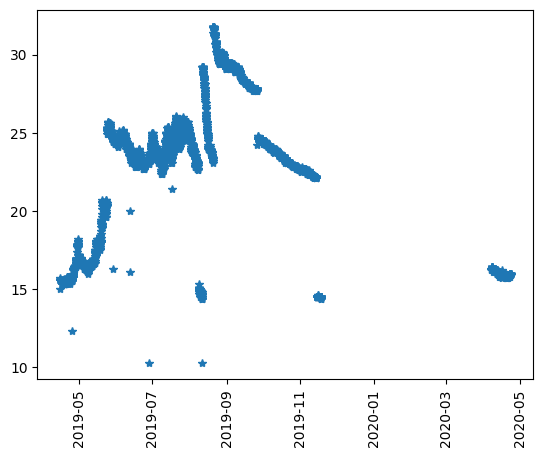

In [89]:
plt.plot(panj['date'], panj['resVal'], '*')
plt.xticks(rotation='vertical')

In [90]:
panj2 = pd.read_csv(r'./data/Table_IV_Colony_management.csv')

In [91]:
panj2 = panj2.rename(columns={'eventY': 'year', 'eventM': 'month', 'eventD': 'day'})
panj2 = panj2[panj2.day != 00] #neke meritve imajo dan 00, kar pythonu ni vsec
panj2["date"] = pd.to_datetime(panj2[['year', 'month', 'day']])
#panj["date"] = pd.to_datetime(panj.year*10000+panj.month*100+panj.day+0.1*panj.day,format='%Y%m%d%H')
panj2 = panj2.drop(['year', "month", "day", 'eventId', "beeKeeperID"], axis=1)
panj2.head()

,siteNo,hiveNo,eventType,inoutType,inoutQuantity,inoutUnit,inoutUnit_desc,clinicalSigns,eventDescription,date
0,2,7,OUTPUT,Foundation comb,0.128,G167A,Kilogram,No clinical signs,burr comb removed,2020-07-09
1,1,6,INPUT,Sucrose,6.250,G167A,Kilogram,No clinical signs,sucrose added-ApiInvert,2019-08-20
2,2,2,OTHER,NaN,NaN,NaN,.,No clinical signs,329 dead bees in front of hive,2019-07-29
3,4,1,OUTPUT,Super + 10 frames,5.000,G167A,Kilogram,No clinical signs,NaN,2020-06-19
4,1,2,CLINICAL SIGNS,NaN,NaN,NaN,.,Black shiny honey bees,some bees shiny,2019-09-09


In [92]:
panj2 = panj2.loc[panj2['siteNo'] == 3]
panj2 = panj2.loc[panj2['hiveNo'] == 1]
panj2 = panj2.drop(['siteNo', "hiveNo"], axis=1)

In [93]:
panj2.head()

,eventType,inoutType,inoutQuantity,inoutUnit,inoutUnit_desc,clinicalSigns,eventDescription,date
68,CLINICAL SIGNS,NaN,NaN,NaN,.,Slumped larvae,NaN,2019-07-30
94,INPUT,Queen excluder,0.800,G167A,Kilogram,No clinical signs,NaN,2019-06-28
109,SAMPLE,NaN,NaN,NaN,.,No clinical signs,NaN,2019-07-31
214,OUTPUT,Brood comb,0.031,G167A,Kilogram,No clinical signs,NaN,2019-07-17
404,INPUT,Sucrose,14.700,G167A,Kilogram,No clinical signs,NaN,2019-08-11


# VREME iz http://rp5.am/Weather_archive_in_Flakkebjerg (lokacija izbranega panja)

In [94]:
vreme = pd.read_csv(r'./data/vreme_flakken.csv', delimiter=';')

In [95]:
vreme["date"]= pd.to_datetime(vreme["date"])

In [96]:
vreme.head()

,date,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,???
0,2020-02-05 23:00:00,7.6,752.5,755.7,1.5,95.0,Wind blowing from the west-northwest,3,NaN,NaN,...,NaN,20.0,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-05 22:00:00,8.3,752.0,755.1,1.4,92.0,Wind blowing from the west-northwest,4,NaN,NaN,...,NaN,45.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-05 21:00:00,7.8,751.6,754.7,1.5,91.0,Wind blowing from the west,2,NaN,NaN,...,NaN,35.0,6.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-05 20:00:00,8.6,751.0,754.0,1.4,86.0,Wind blowing from the west,2,NaN,NaN,...,NaN,50.0,6.4,0.4,12.0,NaN,NaN,NaN,NaN,NaN
4,2020-02-05 19:00:00,10.7,750.6,753.7,1.2,71.0,Wind blowing from the west-northwest,4,NaN,NaN,...,NaN,50.0,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


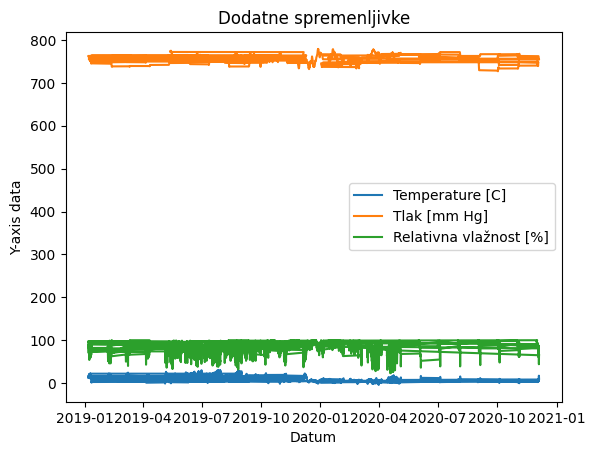

In [97]:
plt.plot(vreme['date'], vreme['T'], label ='Temperature [C]')
plt.plot(vreme['date'], vreme['Po'], label ='Tlak [mm Hg]')
plt.plot(vreme['date'], vreme['U'], label ='Relativna vlažnost [%]')

plt.xlabel("Datum")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('Dodatne spremenljivke')
plt.show()

In [100]:
vreme = vreme.replace("Trace of precipitation", 0)
vreme = vreme.replace("No precipitation", 0)
vreme['RRR'] = vreme['RRR'] = vreme['RRR'].fillna(0)
vreme['sss'] = vreme['sss'] = vreme['sss'].fillna(0)
vreme['???'] = vreme['???'] = vreme['???'].fillna(0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


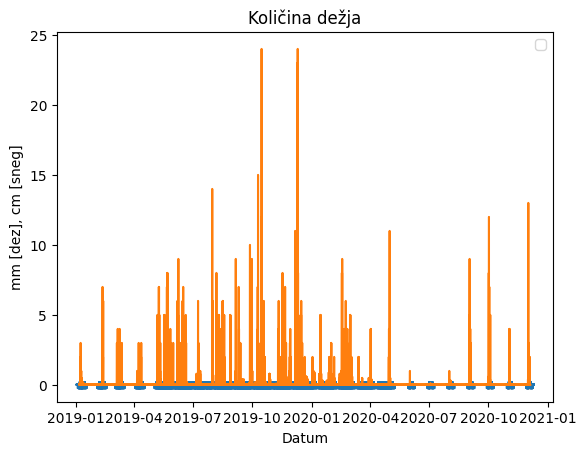

In [101]:
plt.plot(vreme['date'], vreme['???'], '*')
plt.plot(vreme['date'], vreme['RRR'], '-')

plt.xlabel("Datum")
plt.ylabel("mm [dez], cm [sneg]")
plt.legend()
plt.title('Količina dežja')
plt.show()

In [102]:
vreme.head()

,date,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,???
0,2020-02-05 23:00:00,7.6,752.5,755.7,1.5,95.0,Wind blowing from the west-northwest,3,NaN,NaN,...,NaN,20.0,6.9,0,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-05 22:00:00,8.3,752.0,755.1,1.4,92.0,Wind blowing from the west-northwest,4,NaN,NaN,...,NaN,45.0,7.0,0,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-05 21:00:00,7.8,751.6,754.7,1.5,91.0,Wind blowing from the west,2,NaN,NaN,...,NaN,35.0,6.4,0,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-05 20:00:00,8.6,751.0,754.0,1.4,86.0,Wind blowing from the west,2,NaN,NaN,...,NaN,50.0,6.4,0.4,12.0,NaN,NaN,NaN,0.0,0.0
4,2020-02-05 19:00:00,10.7,750.6,753.7,1.2,71.0,Wind blowing from the west-northwest,4,NaN,NaN,...,NaN,50.0,5.5,0,NaN,NaN,NaN,NaN,0.0,0.0
